## Task 2 (5 days)
#### Starting from this task, we assume that you already have the basic machine learning foundation, that is, you have mastered the principles and uses of basic algorithms such as KNN, CART, Bayes, LR, SVM, RF, Boosting, etc., which we will use in the following content Machine Learning Algorithm Assisted Business Analysis.

#### If you have not systematically studied machine learning, it is recommended to follow the following series of tutorials to get started:

#### https://ailearning.apachecn.org/#/docs/ml/1

#### This task will be the regression of supervised learning: it aims to combine the data of January with the climate of the day - connect the weather data with tripdata, and build a time-based order passenger flow peak predictor in units of days to predict each day. Estimated outbound passenger flow of a zip code area at that time.

#### If the amount of data is not enough to complete the training of 265 regions, more monthly data can be added.

#### The time-sharing predictor can suggest and optimize the scheduling of macro operations, and can maximize the profit of the driver's trip while avoiding unnecessary congestion.

#### In this regression task, Pickup_datetime and PULocationID will be the core independent variables, and the rest of the data needs to be properly discarded according to engineering requirements to reduce redundant algorithm performance consumption.

#### We recommend using the basic Lasso regression model to select basic high-correlation features, and then send the selected features to more advanced algorithms for training, such as: CART→GBDT→XGBoost or RNN→LSTM→GRU.

#### After tuning to obtain the optimal prediction results, you need to report its advantages and algorithm performance consumption, and compare the prediction performance of all the algorithms you have used horizontally, and finally use all the data to train a model that can be put into downstream use.

In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import copy
import itertools
import pickle

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import plotly.graph_objects as go
from scipy.interpolate import griddata
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

In [2]:
RETRAIN = False

try:
    with open('results.pkl', 'rb') as fresults:
        results = pickle.load(fresults)
    with open('lstm_results.pkl', 'rb') as flstm_results:
        lstm_results = pickle.load(flstm_results)
except:
    print('16-hour Training Commencing...')
    RETRAIN = True

In [3]:
def parquet_to_df(path):
    df = pq.read_table(path)
    df = df.to_pandas()
    return df

def extend_trips(ogdf, newdf):
    return ogdf.append(newdf, ignore_index=True)

def total_months_to_filename(total_months):
    months = [m[-2:]for m in ['0'+str(m) for m in list(range(1,total_months+1))]]
    trips = pd.DataFrame()

    for month in months:
        path = f'data/fhvhv_tripdata_2021-{month}.parquet'
        df = parquet_to_df(path)
        df = df.sample(n=len(df)//4, random_state=42)
        trips = extend_trips(trips, df)
    return trips

In [4]:
trips = total_months_to_filename(12)

In [5]:
weather_2021_path = "data/nyc 2021-01-01 to 2021-12-31.csv"
weather_2021 = pd.read_csv(weather_2021_path)

#weather_jan_path = "data/nyc 2021-01-01 to 2021-01-31.csv"
#weather_jan = pd.read_csv(weather_jan_path)

features = ['temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 
            'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 
            'cloudcover', 'visibility', 'uvindex']

weather_2021 = weather_2021[['datetime']+features]
weather_2021.head()

,datetime,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,uvindex
0,2021-01-01,2.5,-0.2,-3.0,67.8,15.33,100,0.0,0.0,15.5,69.8,1028.9,50.6,14.0,3
1,2021-01-02,5.8,3.6,1.2,74.0,2.38,100,1.9,0.6,25.5,246.9,1012.4,63.9,12.2,5
2,2021-01-03,2.5,-1.6,-0.5,80.7,5.09,100,1.2,1.7,24.1,66.4,1017.0,81.5,13.2,1
3,2021-01-04,3.6,1.1,-0.2,76.6,0.84,100,0.5,0.7,17.3,141.1,1014.6,89.3,15.6,4
4,2021-01-05,3.8,1.3,-1.5,68.7,0.00,0,0.0,0.1,15.2,124.4,1013.1,98.8,16.0,2


In [6]:
trips['pickup_datetime'] = pd.to_datetime(trips['pickup_datetime'])
trips['date'] = trips['pickup_datetime'].dt.date
trips['weekday'] = trips['pickup_datetime'].dt.weekday

weather_2021['datetime'] = pd.to_datetime(weather_2021['datetime'])
weather_2021['date'] = weather_2021['datetime'].dt.date

grouped_trips = trips.groupby(['date', 'PULocationID']).agg({'DOLocationID': 'size', 'weekday': 'first'})
grouped_trips = grouped_trips.rename(columns={'DOLocationID': 'total_rides'}).reset_index()

trips_weather_df = grouped_trips.merge(weather_2021, on=['date'], how='left')
trips_weather_df = pd.get_dummies(data=trips_weather_df, columns=["weekday"])
weekday_dummies = [f'weekday_{n}' for n in range(7)]
features = features + weekday_dummies

trips_weather_df.head()

,date,PULocationID,total_rides,datetime,temp,feelslike,dew,humidity,precip,precipprob,...,cloudcover,visibility,uvindex,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2021-01-01,1,5,2021-01-01,2.5,-0.2,-3.0,67.8,15.33,100,...,50.6,14.0,3,0,0,0,0,1,0,0
1,2021-01-01,3,307,2021-01-01,2.5,-0.2,-3.0,67.8,15.33,100,...,50.6,14.0,3,0,0,0,0,1,0,0
2,2021-01-01,4,340,2021-01-01,2.5,-0.2,-3.0,67.8,15.33,100,...,50.6,14.0,3,0,0,0,0,1,0,0
3,2021-01-01,5,24,2021-01-01,2.5,-0.2,-3.0,67.8,15.33,100,...,50.6,14.0,3,0,0,0,0,1,0,0
4,2021-01-01,6,46,2021-01-01,2.5,-0.2,-3.0,67.8,15.33,100,...,50.6,14.0,3,0,0,0,0,1,0,0


In [7]:
holidays_2021 = {
    "2021-01-01": "new_years_day",
    "2021-01-18": "martin_luther_king_jr_day",
    "2021-02-07": "super_bowl_sunday",
    "2021-02-14": "valentines_day",
    "2021-02-15": "presidents_day",
    "2021-03-17": "st_patricks_day",
    "2021-04-01": "april_fools_day",
    "2021-04-04": "easter_sunday",
    "2021-05-09": "mothers_day",
    "2021-05-31": "memorial_day",
    "2021-06-19": "juneteenth",
    "2021-06-20": "fathers_day",
    "2021-07-04": "independence_day",
    "2021-09-06": "labor_day",
    "2021-09-11": "patriot_day",
    "2021-10-11": "columbus_day",
    "2021-10-31": "halloween",
    "2021-11-11": "veterans_day",
    "2021-11-25": "thanksgiving_day",
    "2021-11-26": "black_friday",
    "2021-11-28": "hanukkah",
    "2021-11-29": "cyber_monday",
    "2021-12-24": "christmas_eve",
    "2021-12-25": "christmas_day",
    "2021-12-31": "new_years_eve"
}

holidays_df = pd.DataFrame(list(holidays_2021.items()), columns=['date', 'holiday_name'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

trips_weather_df['date'] = pd.to_datetime(trips_weather_df['date'])
trips_weather_df = trips_weather_df.merge(holidays_df, on='date', how='left')

for holiday in holidays_2021.values():
    trips_weather_df[holiday] = trips_weather_df['holiday_name'] == holiday

trips_weather_df = trips_weather_df.drop(columns=['holiday_name'])
holiday_columns = list(holidays_2021.values())

trips_weather_df.head()

,date,PULocationID,total_rides,datetime,temp,feelslike,dew,humidity,precip,precipprob,...,columbus_day,halloween,veterans_day,thanksgiving_day,black_friday,hanukkah,cyber_monday,christmas_eve,christmas_day,new_years_eve
0,2021-01-01,1,5,2021-01-01,2.5,-0.2,-3.0,67.8,15.33,100,...,False,False,False,False,False,False,False,False,False,False
1,2021-01-01,3,307,2021-01-01,2.5,-0.2,-3.0,67.8,15.33,100,...,False,False,False,False,False,False,False,False,False,False
2,2021-01-01,4,340,2021-01-01,2.5,-0.2,-3.0,67.8,15.33,100,...,False,False,False,False,False,False,False,False,False,False
3,2021-01-01,5,24,2021-01-01,2.5,-0.2,-3.0,67.8,15.33,100,...,False,False,False,False,False,False,False,False,False,False
4,2021-01-01,6,46,2021-01-01,2.5,-0.2,-3.0,67.8,15.33,100,...,False,False,False,False,False,False,False,False,False,False


In [8]:
def feature_importantance_test(df, features, deg):
    X = df[features]
    y = df['total_rides']

    lasso = Lasso(max_iter=10000)
    lasso.fit(X, y)

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(X)

    poly = PolynomialFeatures(degree=deg, interaction_only=False, include_bias=False)
    poly_features_ = poly.fit_transform(scaled_features)

    lasso = Lasso(max_iter=10000)
    lasso.fit(poly_features_, y)

    influence = lasso.coef_
    influences = {f:v for f,v in zip(poly.get_feature_names_out(features), influence) if v!=0}
    influences = {k:v for k,v in sorted(influences.items(), key=lambda x:-abs(x[1]))}
    #selected_features_ = influences.keys()
    return influences

In [9]:
def plot_influences(influences, absolute=True):
    features = list(influences.keys())
    values = list(influences.values())
    if absolute:
        values = [abs(v) for v in values]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(features, values, marker='o')

    ax.set_title('Feature Influences')
    ax.set_xlabel('Features')
    ax.set_ylabel('Influence')

    plt.xticks(rotation=90)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

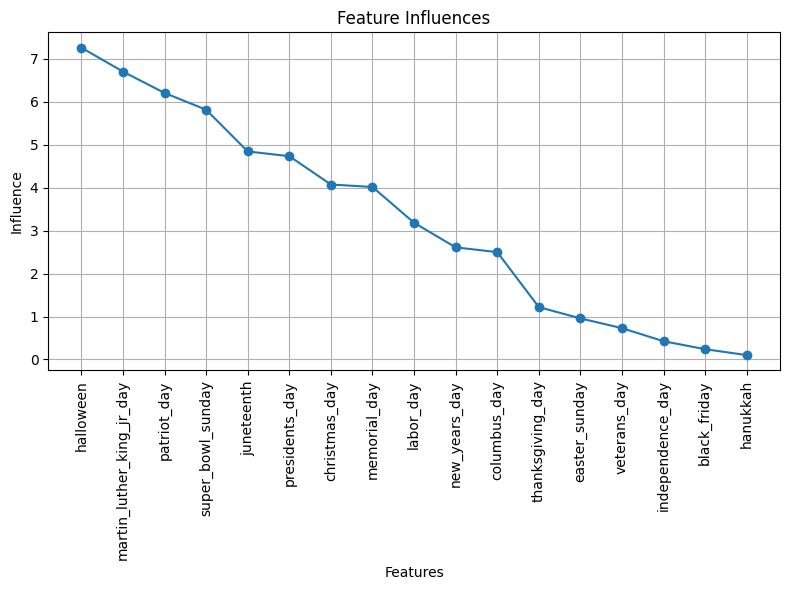

In [10]:
influences_holiday = feature_importantance_test(trips_weather_df, holiday_columns, 1)
plot_influences(influences_holiday)

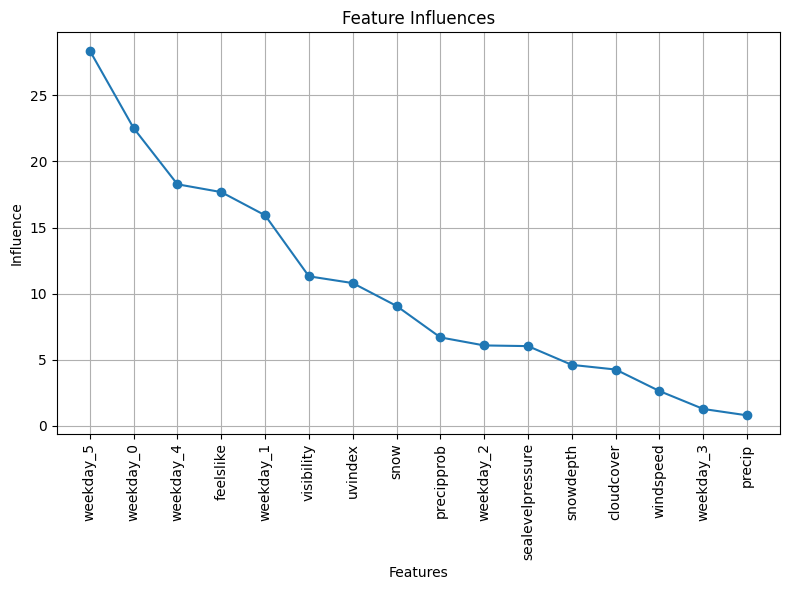

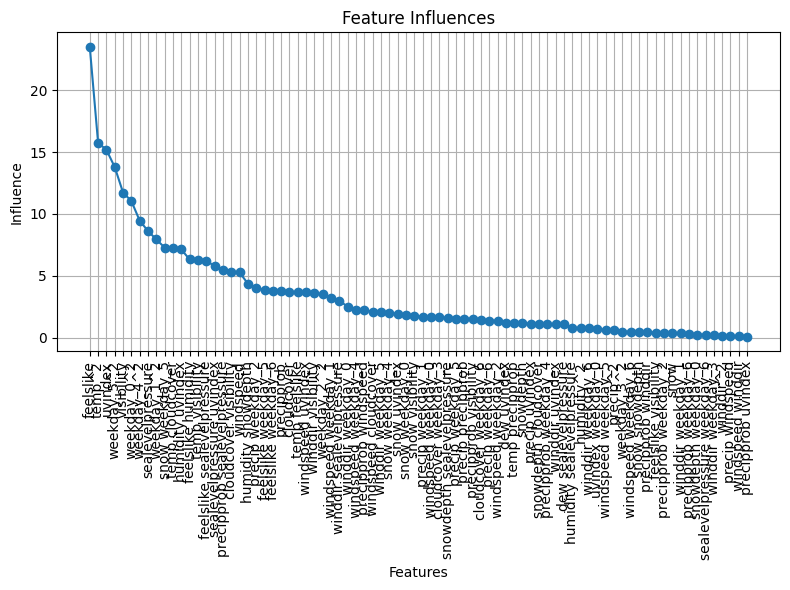

In [11]:
influences_deg_1 = feature_importantance_test(trips_weather_df, features, 1)
plot_influences(influences_deg_1)

influences_deg_2 = feature_importantance_test(trips_weather_df, features, 2)
plot_influences(influences_deg_2)

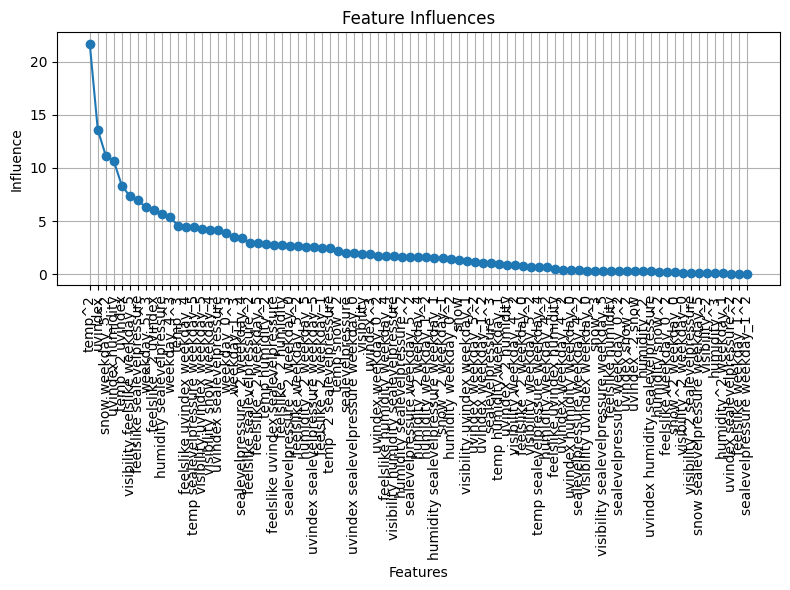

In [12]:
key_features = ['visibility', 'temp', 'feelslike', 'uvindex', 'humidity', 'snow', 'sealevelpressure', 'weekday_0', 'weekday_1', 'weekday_4', 'weekday_5']
#temp^2 humidity*uvindex
influences_deg_3 = feature_importantance_test(trips_weather_df, key_features, 3)
plot_influences(influences_deg_3)

In [13]:
key_influences = {k:v for k,v in sorted(influences_deg_2.items(), key=lambda x:-abs(x[1])) if abs(v)>5}
key_influences

#key_influences = {k:v for k,v in sorted(influences_deg_3.items(), key=lambda x:-abs(x[1])) if abs(v)>5}
#key_influences

{'feelslike': 23.514744324012725,
 'temp^2': -15.7550064634284,
 'uvindex': -15.190067514955238,
 'weekday_5^2': 13.791179493697268,
 'visibility': 11.730037135386802,
 'weekday_0^2': -11.047972126751125,
 'weekday_4^2': 9.453512722623193,
 'sealevelpressure': 8.622934136254996,
 'weekday_1^2': -7.935645626574191,
 'snow weekday_5': -7.28465450080745,
 'temp cloudcover': -7.278836798219348,
 'humidity uvindex': 7.128516129415614,
 'feelslike humidity': 6.322681268817153,
 'temp visibility': -6.2991613002186995,
 'feelslike sealevelpressure': -6.1891822802793355,
 'sealevelpressure uvindex': -5.806733069038018,
 'precipprob sealevelpressure': -5.468022751594851,
 'cloudcover visibility': -5.295631646358889,
 'windspeed': 5.2745601111528915}

In [14]:
def get_influence_combinations_df(df, keeps, commands):
    old_df = copy.deepcopy(df)
    scaler = StandardScaler()
    old_df[features] = scaler.fit_transform(old_df[features])
    out_df = copy.deepcopy(df[keeps])

    for command in commands:
        parts = command.split()
        result = None
        col_name = ''
        for part in parts:
            if '^' in part:
                col, power = part.split('^')
                power = int(power)
                if result is None:
                    result = old_df[col] ** power
                else:
                    result *= old_df[col] ** power
            else:
                if result is None:
                    result = old_df[part]
                else:
                    result *= old_df[part]
            col_name += '_' + part
        col_name = col_name[1:]
        out_df[col_name] = result
    
    return out_df

In [15]:
train_test_df = get_influence_combinations_df(trips_weather_df, ['date', 'PULocationID', 'total_rides', 'datetime'], list(key_influences.keys()))
train_test_df = pd.concat([train_test_df, trips_weather_df[list(influences_holiday.keys())]], axis=1)

col_val_counts = [len(set(train_test_df[col])) for col in train_test_df.columns]
cols_to_convert = [train_test_df.columns[i] for i, count in enumerate(col_val_counts) if count == 2]
for col in cols_to_convert:
    most_common_val = train_test_df[col].mode()[0]
    train_test_df[col] = train_test_df[col].apply(lambda x: 0 if x == most_common_val else 1)
train_test_df.head()

,date,PULocationID,total_rides,datetime,feelslike,temp^2,uvindex,weekday_5^2,visibility,weekday_0^2,...,memorial_day,labor_day,new_years_day,columbus_day,thanksgiving_day,easter_sunday,veterans_day,independence_day,black_friday,hanukkah
0,2021-01-01,1,5,2021-01-01,-1.236302,1.596202,-1.1477,0,-0.387814,0,...,0,0,1,0,0,0,0,0,0,0
1,2021-01-01,3,307,2021-01-01,-1.236302,1.596202,-1.1477,0,-0.387814,0,...,0,0,1,0,0,0,0,0,0,0
2,2021-01-01,4,340,2021-01-01,-1.236302,1.596202,-1.1477,0,-0.387814,0,...,0,0,1,0,0,0,0,0,0,0
3,2021-01-01,5,24,2021-01-01,-1.236302,1.596202,-1.1477,0,-0.387814,0,...,0,0,1,0,0,0,0,0,0,0
4,2021-01-01,6,46,2021-01-01,-1.236302,1.596202,-1.1477,0,-0.387814,0,...,0,0,1,0,0,0,0,0,0,0


In [16]:
selected_features = list(train_test_df.columns)[4:]
X = train_test_df[selected_features]
y = train_test_df['total_rides']
X.head()

,feelslike,temp^2,uvindex,weekday_5^2,visibility,weekday_0^2,weekday_4^2,sealevelpressure,weekday_1^2,snow_weekday_5,...,memorial_day,labor_day,new_years_day,columbus_day,thanksgiving_day,easter_sunday,veterans_day,independence_day,black_friday,hanukkah
0,-1.236302,1.596202,-1.1477,0,-0.387814,0,1,1.84859,0,0.08959,...,0,0,1,0,0,0,0,0,0,0
1,-1.236302,1.596202,-1.1477,0,-0.387814,0,1,1.84859,0,0.08959,...,0,0,1,0,0,0,0,0,0,0
2,-1.236302,1.596202,-1.1477,0,-0.387814,0,1,1.84859,0,0.08959,...,0,0,1,0,0,0,0,0,0,0
3,-1.236302,1.596202,-1.1477,0,-0.387814,0,1,1.84859,0,0.08959,...,0,0,1,0,0,0,0,0,0,0
4,-1.236302,1.596202,-1.1477,0,-0.387814,0,1,1.84859,0,0.08959,...,0,0,1,0,0,0,0,0,0,0


In [17]:
class RecurrentModel(nn.Module):
    def __init__(self, model_type, input_size, hidden_size=100, num_layers=2, fc_size=100, dropout=0.25):
        super(RecurrentModel, self).__init__()
        
        if model_type == 'RNN':
            self.recurrent = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        elif model_type == 'LSTM':
            self.recurrent = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        elif model_type == 'GRU':
            self.recurrent = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        else:
            raise ValueError("model_type should be 'RNN', 'LSTM', or 'GRU'")
        
        self.fc1 = nn.Linear(hidden_size, fc_size)
        self.fc2 = nn.Linear(fc_size, fc_size)
        self.fc3 = nn.Linear(fc_size, fc_size)
        #self.fc4 = nn.Linear(fc_size, fc_size)
        #self.fc5 = nn.Linear(fc_size, fc_size)
        #self.fc6 = nn.Linear(fc_size, fc_size)
        self.fc_fin = nn.Linear(fc_size, 1)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out, _ = self.recurrent(x)
        out = self.fc1(out[:, -1, :])
        out = self.dropout(self.relu(out))
        out = self.fc2(out)
        out = self.dropout(self.relu(out))
        out = self.fc3(out)
        out = self.dropout(self.relu(out))
        #out = self.fc4(out)
        #out = self.dropout(self.relu(out))
        #out = self.fc5(out)
        #out = self.dropout(self.relu(out))
        #out = self.fc6(out)
        #out = self.dropout(self.relu(out))
        out = self.fc_fin(out)
        return out

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
            
def create_model(model_type, input_size, hidden_size=128, num_layers=2, fc_size=128, dropout=0.4):
    return RecurrentModel(model_type, input_size, hidden_size, num_layers, fc_size, dropout)

In [18]:
def train_and_evaluate(model, region_id, data, selected_features, model_name):
    region_data = data[data['PULocationID'] == region_id]
    
    if len(region_data) < 6:
        print(f"Skipping region {region_id} due to insufficient data")
        return 0, 0, [0], [0]
    
    X = region_data[selected_features].values
    y = region_data['total_rides'].values

    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    X_train = torch.tensor(X_train, dtype=torch.float32).cuda().unsqueeze(1)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).cuda()
    X_val = torch.tensor(X_val, dtype=torch.float32).cuda().unsqueeze(1)
    y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).cuda()
    X_test = torch.tensor(X_test, dtype=torch.float32).cuda().unsqueeze(1)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).cuda()

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
    
    num_epochs = 256
    best_val_loss = float('inf')
    early_stop_counter = 0
    patience = 32
    early_stopping = EarlyStopping(patience=patience)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered ({epoch})")
            break
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'models/{model_name}_best_model.pth')
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                break
    
    model.load_state_dict(torch.load(f'models/{model_name}_best_model.pth'))
    
    model.eval()
    test_loss = 0.0
    y_preds = []
    y_trues = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()
            y_preds.extend(y_pred.cpu().numpy())
            y_trues.extend(y_batch.cpu().numpy())
    
    test_loss /= len(test_loader)
    y_preds = np.array(y_preds).flatten()
    y_trues = np.array(y_trues).flatten()
    
    r2 = r2_score(y_trues, y_preds)
    
    return test_loss, r2, y_preds.tolist(), y_trues.tolist()

In [19]:
input_size = len(selected_features)
region_ids = train_test_df['PULocationID'].unique()

if RETRAIN:
    trained_rnn_models = {}
    trained_lstm_models = {}
    trained_gru_models = {}
    results = {}

    for region_id in region_ids:
        print(f"Training for region: {region_id}")
        results[region_id] = {}
        
        # Train RNN model
        print(f"Training RNN for region {region_id}")
        rnn_model = create_model('RNN', input_size).cuda()
        rnn_test_loss, rnn_r2, rnn_p, rnn_t = train_and_evaluate(rnn_model, region_id, train_test_df, selected_features, f'rnn_{region_id}')
        results[region_id]['RNN'] = {'Test Loss': rnn_test_loss, 'R^2': rnn_r2, 'Predictions': rnn_p, 'Truths': rnn_t}
        trained_rnn_models[region_id] = rnn_model
        
        # Train LSTM model
        print(f"Training LSTM for region {region_id}")
        lstm_model = create_model('LSTM', input_size).cuda()
        lstm_test_loss, lstm_r2, lstm_p, lstm_t = train_and_evaluate(lstm_model, region_id, train_test_df, selected_features, f'lstm_{region_id}')
        results[region_id]['LSTM'] = {'Test Loss': lstm_test_loss, 'R^2': lstm_r2, 'Predictions': lstm_p, 'Truths': lstm_t}
        trained_lstm_models[region_id] = lstm_model
        
        # Train GRU model
        print(f"Training GRU for region {region_id}")
        gru_model = create_model('GRU', input_size).cuda()
        gru_test_loss, gru_r2, gru_p, gru_t = train_and_evaluate(gru_model, region_id, train_test_df, selected_features, f'gru_{region_id}')
        results[region_id]['GRU'] = {'Test Loss': gru_test_loss, 'R^2': gru_r2, 'Predictions': gru_p, 'Truths': gru_t}
        trained_gru_models[region_id] = gru_model
        
        print(f"Results for region {region_id}:")
        print(f"RNN - Test Loss: {rnn_test_loss}, R^2: {rnn_r2}")
        print(f"LSTM - Test Loss: {lstm_test_loss}, R^2: {lstm_r2}")
        print(f"GRU - Test Loss: {gru_test_loss}, R^2: {gru_r2}")

    with open('results.pkl', 'wb') as fresults:
        pickle.dump(results, fresults)

else:
    trained_rnn_models = {}
    trained_lstm_models = {}
    trained_gru_models = {}
    for region_id in region_ids:
        try:
            rnn_model = create_model('RNN', input_size).cuda()
            rnn_model.load_state_dict(torch.load(f'models/rnn_{region_id}_best_model.pth'))
            trained_rnn_models[region_id] = rnn_model

            lstm_model = create_model('LSTM', input_size).cuda()
            lstm_model.load_state_dict(torch.load(f'models/lstm_{region_id}_best_model.pth'))
            trained_lstm_models[region_id] = lstm_model

            gru_model = create_model('GRU', input_size).cuda()
            gru_model.load_state_dict(torch.load(f'models/gru_{region_id}_best_model.pth'))
            trained_gru_models[region_id] = gru_model
        except:
            print(f"Region {region_id} Missing...")

Region 105 Missing...
Region 264 Missing...


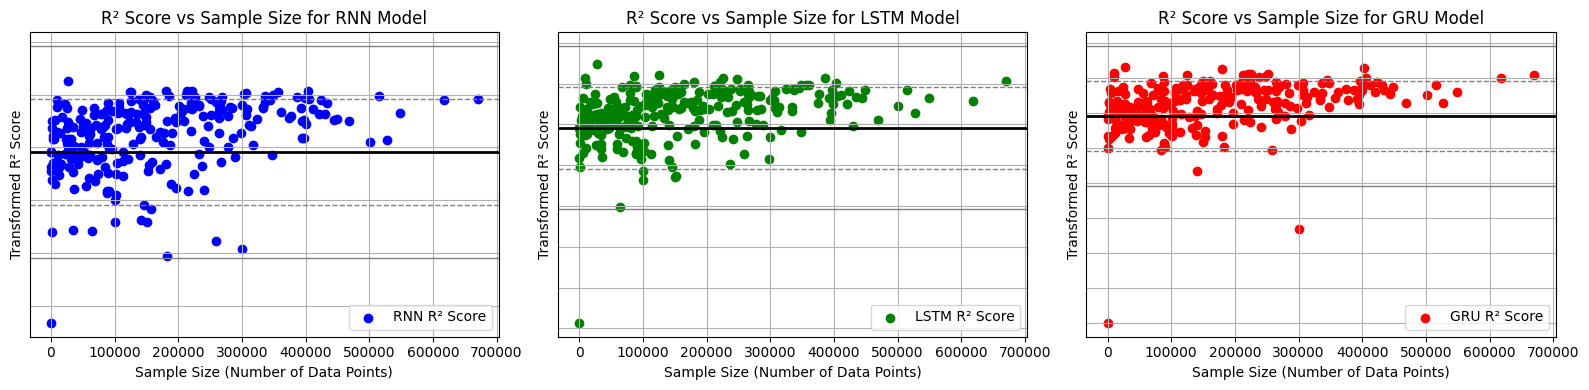

In [20]:
region_ids = list(results.keys())
rnn_r2_scores = [results[region_id]['RNN']['R^2'] for region_id in region_ids]
lstm_r2_scores = [results[region_id]['LSTM']['R^2'] for region_id in region_ids]
gru_r2_scores = [results[region_id]['GRU']['R^2'] for region_id in region_ids]

sample_sizes = [train_test_df[train_test_df['PULocationID'] == region_id]['total_rides'].sum() for region_id in region_ids]

all_r2_scores = np.array(rnn_r2_scores + lstm_r2_scores + gru_r2_scores)
all_r2_scores = pd.Series(all_r2_scores).dropna().tolist()
min_r2 = np.nanmin(all_r2_scores)
offset = abs(min_r2) + 1

rnn_r2_scores_shifted = [s+offset if s is not None else None for s in rnn_r2_scores]
lstm_r2_scores_shifted = [s+offset if s is not None else None for s in lstm_r2_scores]
gru_r2_scores_shifted = [s+offset if s is not None else None for s in gru_r2_scores]

fig, axs = plt.subplots(1, 3, figsize=(16, 4))

axs[0].scatter(sample_sizes, rnn_r2_scores_shifted, label='RNN R² Score', color='blue')
axs[0].set_xlabel('Sample Size (Number of Data Points)')
axs[0].set_ylabel('Transformed R² Score')
axs[0].set_title('R² Score vs Sample Size for RNN Model')
axs[0].legend()
axs[0].grid(True)
axs[0].axhline(y=offset, color='black', linestyle='-', linewidth=2)
axs[0].axhline(y=offset+1, color='gray', linestyle='-', linewidth=1)
axs[0].axhline(y=offset-1, color='gray', linestyle='-', linewidth=1)
axs[0].axhline(y=offset+0.5, color='gray', linestyle='--', linewidth=1)
axs[0].axhline(y=offset-0.5, color='gray', linestyle='--', linewidth=1)
axs[0].tick_params(axis='y', which='both', left=False, labelleft=False)

axs[1].scatter(sample_sizes, lstm_r2_scores_shifted, label='LSTM R² Score', color='green')
axs[1].set_xlabel('Sample Size (Number of Data Points)')
axs[1].set_ylabel('Transformed R² Score')
axs[1].set_title('R² Score vs Sample Size for LSTM Model')
axs[1].legend()
axs[1].grid(True)
axs[1].axhline(y=offset, color='black', linestyle='-', linewidth=2)
axs[1].axhline(y=offset+1, color='gray', linestyle='-', linewidth=1)
axs[1].axhline(y=offset-1, color='gray', linestyle='-', linewidth=1)
axs[1].axhline(y=offset+0.5, color='gray', linestyle='--', linewidth=1)
axs[1].axhline(y=offset-0.5, color='gray', linestyle='--', linewidth=1)
axs[1].tick_params(axis='y', which='both', left=False, labelleft=False)

axs[2].scatter(sample_sizes, gru_r2_scores_shifted, label='GRU R² Score', color='red')
axs[2].set_xlabel('Sample Size (Number of Data Points)')
axs[2].set_ylabel('Transformed R² Score')
axs[2].set_title('R² Score vs Sample Size for GRU Model')
axs[2].legend()
axs[2].grid(True)
axs[2].axhline(y=offset, color='black', linestyle='-', linewidth=2)
axs[2].axhline(y=offset+1, color='gray', linestyle='-', linewidth=1)
axs[2].axhline(y=offset-1, color='gray', linestyle='-', linewidth=1)
axs[2].axhline(y=offset+0.5, color='gray', linestyle='--', linewidth=1)
axs[2].axhline(y=offset-0.5, color='gray', linestyle='--', linewidth=1)
axs[2].tick_params(axis='y', which='both', left=False, labelleft=False)

plt.tight_layout()
plt.show()

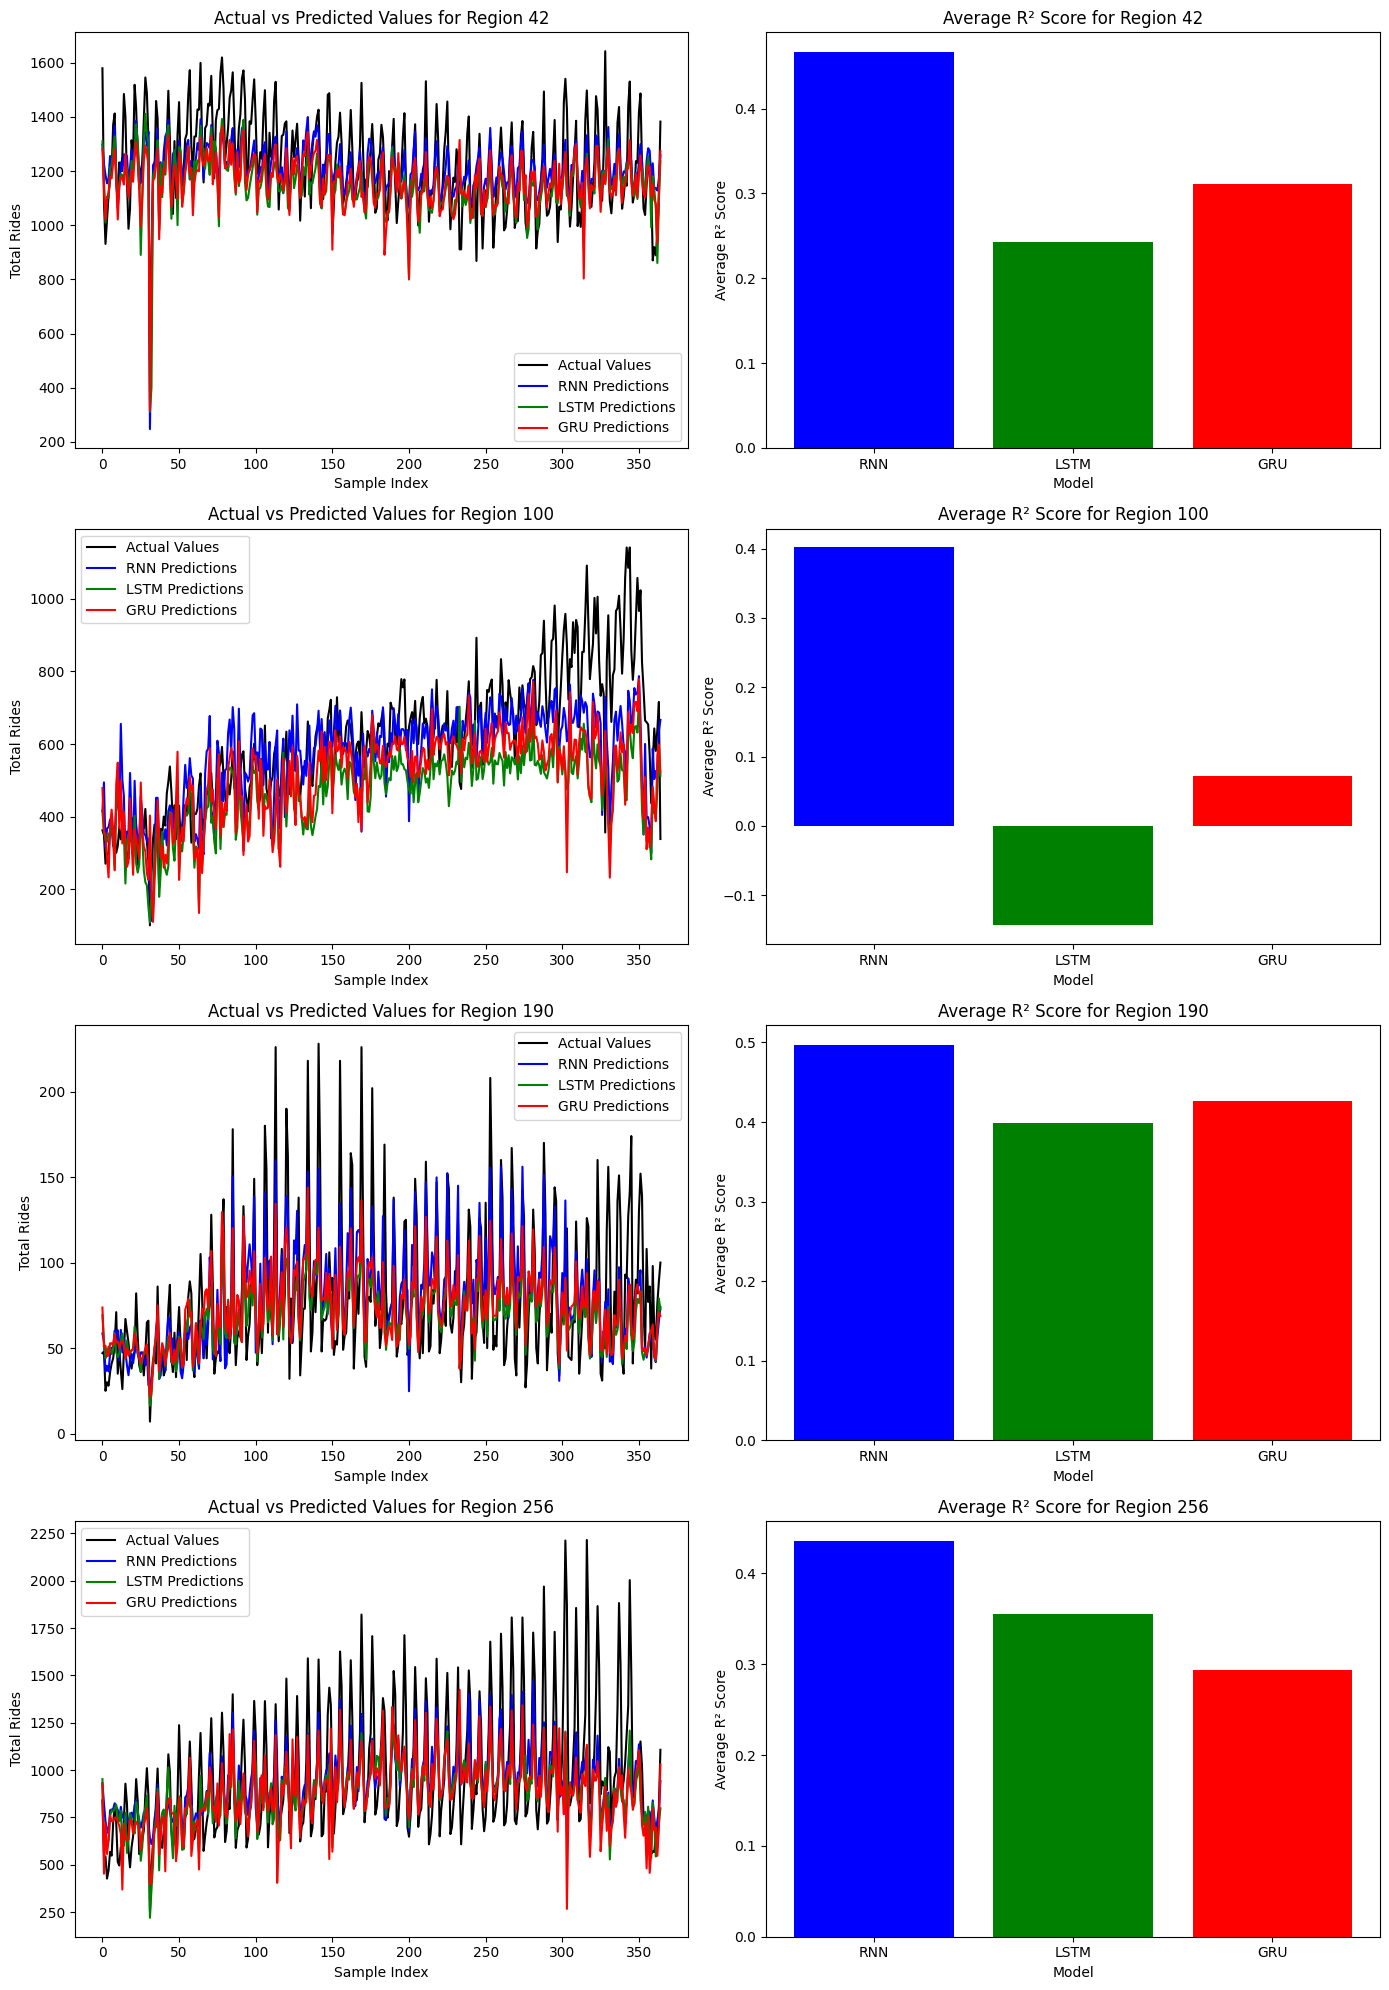

In [21]:
region_ids_to_plot = [42, 100, 190, 256] #[8,9,10,11]

fig, axs = plt.subplots(4, 2, figsize=(14, 20))

for i, sample_region_id in enumerate(region_ids_to_plot):
    region_data = train_test_df[train_test_df['PULocationID'] == sample_region_id]
    X = torch.tensor(region_data[selected_features].values, dtype=torch.float32).unsqueeze(1).cuda()

    rnn_model = trained_rnn_models[sample_region_id]
    lstm_model = trained_lstm_models[sample_region_id]
    gru_model = trained_gru_models[sample_region_id]

    rnn_model.eval()
    lstm_model.eval()
    gru_model.eval()

    with torch.no_grad():
        rnn_predictions = rnn_model(X).cpu().numpy()
        lstm_predictions = lstm_model(X).cpu().numpy()
        gru_predictions = gru_model(X).cpu().numpy()

    actual_values = region_data['total_rides'].values

    axs[i, 0].plot(actual_values, label='Actual Values', color='black')
    axs[i, 0].plot(rnn_predictions, label='RNN Predictions', color='blue')
    axs[i, 0].plot(lstm_predictions, label='LSTM Predictions', color='green')
    axs[i, 0].plot(gru_predictions, label='GRU Predictions', color='red')
    axs[i, 0].set_xlabel('Sample Index')
    axs[i, 0].set_ylabel('Total Rides')
    axs[i, 0].set_title(f'Actual vs Predicted Values for Region {sample_region_id}')
    axs[i, 0].legend()

    rnn_r2_scores = [r2_score(region_data['total_rides'].values, rnn_predictions)]
    lstm_r2_scores = [r2_score(region_data['total_rides'].values, lstm_predictions)]
    gru_r2_scores = [r2_score(region_data['total_rides'].values, gru_predictions)]

    avg_r2_scores = {
        'RNN': sum([x for x in rnn_r2_scores if x is not None]) / len(rnn_r2_scores),
        'LSTM': sum([x for x in lstm_r2_scores if x is not None]) / len(lstm_r2_scores),
        'GRU': sum([x for x in gru_r2_scores if x is not None]) / len(gru_r2_scores)
    }

    axs[i, 1].bar(avg_r2_scores.keys(), avg_r2_scores.values(), color=['blue', 'green', 'red'])
    axs[i, 1].set_xlabel('Model')
    axs[i, 1].set_ylabel('Average R² Score')
    axs[i, 1].set_title(f'Average R² Score for Region {sample_region_id}')

plt.tight_layout()
plt.show()

In [22]:
models = ['RNN', 'LSTM', 'GRU']
scores = {model: [] for model in models}

for r in results:
    for model in models:
        score = results[r][model]['R^2']
        scores[model].append(score)

scores_array = np.array([scores[model] for model in models])
aggregated_scores = np.sum(scores_array, axis=1)
ranking = np.argsort(-aggregated_scores)
ranked_models = np.array(models)[ranking]
ranked_scores = aggregated_scores[ranking]

ranked_model_scores = dict(zip(ranked_models, ranked_scores))
ranked_model_scores

{'LSTM': 46.15729120601654,
 'GRU': 42.63371334344506,
 'RNN': 40.364169723580986}

In [23]:
dropout_values = [0.1, 0.25, 0.4]
hidden_size_values = [32, 64, 128]
fc_size_values = [32, 64, 128]
num_layers_values = [2, 3]
configs = list(itertools.product(hidden_size_values, num_layers_values, fc_size_values, dropout_values))

if RETRAIN:
    lstm_results = {}
    for config in configs:
        hsv, nlv, fsv, dv = config
        model_name = f'LSTM_{hsv}_{nlv}_{fsv}_{dv}'
        lstm_results[model_name] = {}
        for region_id in region_ids:
            print(f"Training for region: {region_id}")
            lstm_results[model_name][region_id] = {}

            print(f"Training {model_name} for region {region_id}")
            lstm_model = create_model('LSTM', input_size, hidden_size=hsv, num_layers=nlv, fc_size=fsv, dropout=dv).cuda()
            lstm_test_loss, lstm_r2, lstm_p, lstm_t = train_and_evaluate(lstm_model, region_id, train_test_df, selected_features, f'lstm_{region_id}')
            
            lstm_results[model_name][region_id] = {'Test Loss': lstm_test_loss, 'R^2': lstm_r2, 'Predictions': lstm_p, 'Truths': lstm_t}

            print(f"Results for region {region_id}:")
            print(f"{model_name} - Test Loss: {lstm_test_loss}, R^2: {lstm_r2}")

    with open('lstm_results.pkl', 'wb') as flstm_results:
        pickle.dump(lstm_results, flstm_results)

In [24]:
scores = {model: [] for model in lstm_results}

for model in lstm_results:
    for loc in lstm_results[model]:
        score = lstm_results[model][loc]['R^2']
        scores[model].append(score)

scores_array = np.array([scores[model] for model in lstm_results])
aggregated_scores = np.sum(scores_array, axis=1)
ranking = np.argsort(-aggregated_scores)
ranked_models = [list(lstm_results.keys())[r] for r in ranking]
ranked_scores = aggregated_scores[ranking]

ranked_model_scores = dict(zip(ranked_models, ranked_scores))

In [25]:
scores_dict = {model_ind: 0 for model_ind in range(len(configs))}

for i, config in enumerate(configs):
    hidden_size, num_layers, fc_size, dropout = config
    score = aggregated_scores[i]
    values = {
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'fc_size': fc_size,
        'dropout': dropout,
        'score': score
    }
    scores_dict[i] = values

In [26]:
x = []
y = []
z = []

for idx, values in scores_dict.items():
    hidden_size = values['hidden_size']
    fc_size = values['fc_size']
    score = values['score']
    num_layers = values['num_layers']
    dropout = values['dropout']
    
    x.append(hidden_size)
    y.append(fc_size)
    z.append(score)

x = np.array(x)
y = np.array(y)
z = np.array(z)

num_layers_values = sorted(set(v['num_layers'] for v in scores_dict.values()))
dropout_values = sorted(set(v['dropout'] for v in scores_dict.values()))

fig = make_subplots(rows=len(num_layers_values), cols=len(dropout_values),
                    subplot_titles=[f'Layers: {nl}, Dropout: {dp}' for nl in num_layers_values for dp in dropout_values],
                    specs=[[{'type': 'surface'} for _ in dropout_values] for _ in num_layers_values])

for row_idx, num_layers in enumerate(num_layers_values):
    for col_idx, dropout in enumerate(dropout_values):
        mask = [(values['num_layers'] == num_layers and values['dropout'] == dropout) for values in scores_dict.values()]
        subplot_x = np.array([values['hidden_size'] for i, values in scores_dict.items() if mask[i]])
        subplot_y = np.array([values['fc_size'] for i, values in scores_dict.items() if mask[i]])
        subplot_z = np.array([values['score'] for i, values in scores_dict.items() if mask[i]])
        
        xi = np.linspace(subplot_x.min(), subplot_x.max(), 100)
        yi = np.linspace(subplot_y.min(), subplot_y.max(), 100)
        X, Y = np.meshgrid(xi, yi)
        Z = griddata((subplot_x, subplot_y), subplot_z, (X, Y), method='cubic')

        fig.add_trace(
            go.Surface(x=xi, y=yi, z=Z, colorscale='Inferno'),
            row=row_idx + 1, col=col_idx + 1
        )

# Update layout
fig.update_layout(
    title='Hyperparameter Tuning Results',
    scene=dict(
        xaxis_title='Hidden Size',
        yaxis_title='FC Size',
        zaxis_title='Score'
    ),
    height=900, width=1200,
    showlegend=False
)

fig.show()

In [27]:
best_results = {}
best_lstm_models = {}
hsv, nlv, fsv, dv = configs[ranking[0]]

if not RETRAIN:
    best_results = {}
    for region_id in region_ids:
        lstm_model = create_model('LSTM', input_size, hidden_size=hsv, num_layers=nlv, fc_size=fsv, dropout=dv).cuda()
        lstm_model.load_state_dict(torch.load(f'best_models/LSTM_{region_id}.pth'))
        best_lstm_models[region_id] = lstm_model
    with open('best_results.pkl', 'rb') as fbest_results:
        best_results = pickle.load(fbest_results)
else:
    for region_id in region_ids:
        print(f"Training for region: {region_id}")
        best_results[region_id] = {}
        lstm_model = create_model('LSTM', input_size, hidden_size=hsv, num_layers=nlv, fc_size=fsv, dropout=dv).cuda()
        lstm_test_loss, lstm_r2, lstm_p, lstm_t = train_and_evaluate(lstm_model, region_id, train_test_df, selected_features, f'lstm_{region_id}')
        best_results[region_id]['LSTM'] = {'Test Loss': lstm_test_loss, 'R^2': lstm_r2, 'Predictions': lstm_p, 'Truths': lstm_t}
        best_lstm_models[region_id] = lstm_model
        torch.save(lstm_model.state_dict(), f'best_models/LSTM_{region_id}.pth')

    with open('best_results.pkl', 'wb') as fbest_results:
        pickle.dump(best_results, fbest_results)

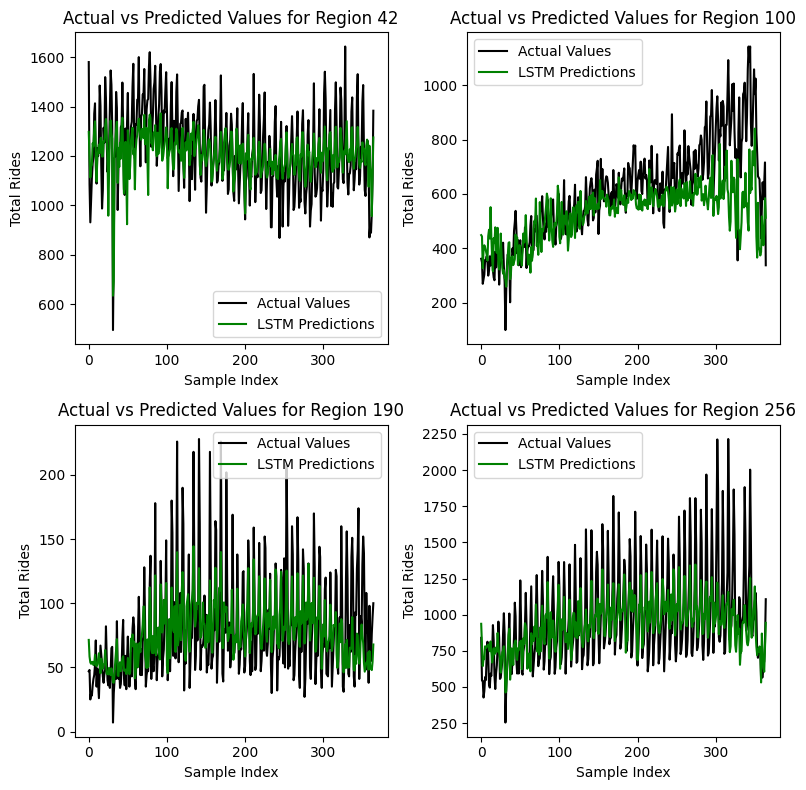

In [28]:
region_ids_to_plot = [42, 100, 190, 256] #[8,9,10,11]
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

for i, sample_region_id in enumerate(region_ids_to_plot):
    region_data = train_test_df[train_test_df['PULocationID'] == sample_region_id]
    X = torch.tensor(region_data[selected_features].values, dtype=torch.float32).unsqueeze(1).cuda()

    lstm_model = best_lstm_models[sample_region_id]
    lstm_model.eval()

    with torch.no_grad():
        lstm_predictions = lstm_model(X).cpu().numpy()

    actual_values = region_data['total_rides'].values

    axs[i//2, i%2].plot(actual_values, label='Actual Values', color='black')
    axs[i//2, i%2].plot(lstm_predictions, label='LSTM Predictions', color='green')
    axs[i//2, i%2].set_xlabel('Sample Index')
    axs[i//2, i%2].set_ylabel('Total Rides')
    axs[i//2, i%2].set_title(f'Actual vs Predicted Values for Region {sample_region_id}')
    axs[i//2, i%2].legend()

plt.tight_layout()
plt.show()

In [29]:
region_r2_dict = dict(zip(best_results.keys(), [best_results[r]['LSTM']['R^2'] for r in best_results.keys()]))

num_cols = 5
num_rows = (len(region_r2_dict) // num_cols) + int(len(region_r2_dict) % num_cols != 0)

matrix = np.full((num_rows, num_cols), np.nan)
for idx, r2 in region_r2_dict.items():
    row = (idx - 1) // num_cols
    col = (idx - 1) % num_cols
    matrix[row, col] = r2

heatmap = go.Heatmap(
    z=matrix,
    colorscale='Inferno',
    colorbar=dict(title='R^2 Value', tickvals=[-1, -0.5, 0, 0.5, 1], ticktext=['-1', '-0.5', '0', '0.5', '1']),
    zmin=-1,
    zmax=1
)

fig = go.Figure(heatmap)

fig.update_layout(
    title='R^2 Values Heatmap for 265 Regions',
    xaxis=dict(
        tickvals=list(range(num_cols)),
        ticktext=[str(i + 1) for i in range(num_cols)],
        showticklabels=True
    ),
    yaxis=dict(
        tickvals=list(range(num_rows)),
        ticktext=[f'{(i*5+1)}~{(i*5+5)}' for i in range(num_rows)],
        showticklabels=True
    ),
    height=800,
    width=400,
    showlegend=False
)

fig.show()